## 特征挑选
分别用IV值和随机森林等进行特征选择

In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
import datetime
import warnings 
warnings.filterwarnings('ignore')

In [19]:
x = pd.read_csv(r"F:\文档\python\load_data\prosper_scale_data_task2.csv",engine="python")
y = pd.read_csv(r"F:\文档\python\load_data\prosper_y_task2.csv",engine="python")
pre = pd.read_csv(r"F:\文档\python\load_data\prosper_scale_pre_task2.csv",engine="python")
print(x.shape,x.head())
print(y.shape,y.head())
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 2018)
print("本数据集有{}行，{}列".format(x.shape[0],x.shape[1]+1))
print("预测集有{}行，{}列".format(pre.shape[0],pre.shape[1]))

(27400, 25)    lp_customerpayments  lp_collectionfees      term  prosperscore  \
0            -1.131970           0.171807 -0.218930     -0.942932   
1            -0.268004           0.171807  2.011061     -1.372728   
2            -0.292640           0.171807 -0.218930      1.206049   
3             0.853180           0.171807 -0.218930      1.206049   
4             2.145247           0.171807 -0.218930      1.635845   

   lp_customerprincipalpayments  revolvingcreditbalance  debttoincomeratio  \
0                     -1.023278               -0.220476          -0.111841   
1                     -0.212830               -0.441610          -0.302122   
2                     -0.212830               -0.266709           0.105623   
3                      1.029346               -0.365315          -0.302122   
4                      2.273615               -0.508444          -0.465220   

   totalcreditlinespast7years  loanfirstdefaultedcyclenumber  \
0                    0.170277           

### 查看label分布（样本是否平衡）

0    0.729599
1    0.270401
Name: label, dtype: float64


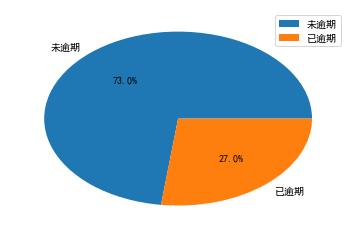

In [21]:
%matplotlib inline

mpl.rcParams["font.sans-serif"] = ["SimHei"]
print(y.label.value_counts(1))
labels = ["未逾期","已逾期"]
plt.pie(y.label.value_counts(),labels=labels,autopct="%3.1f%%")
plt.legend()

### 模型构建
用逻辑回归、svm和决策树；随机森林和XGBoost进行模型构建 评分方式任意，如准确率等。

In [22]:
%%time
# 逻辑回归
log = LogisticRegression(class_weight="balanced",random_state=2018)
log.fit(x_train,y_train)
score_log = log.score(x_test,y_test)
print(score_log)
pred = log.predict(x_test)
print(metrics.accuracy_score(y_test, pred))
# svm
svc = svm.SVC(random_state=2018)
svc.fit(x_train,y_train)
score_svc = svc.score(x_test,y_test)
print(score_svc)
# 决策树
tree = DecisionTreeClassifier(presort=True,random_state=2018)
tree.fit(x_train,y_train)
score_tree = tree.score(x_test,y_test)
print(score_tree)
# 随机森林
forest = RandomForestRegressor(random_state=2018)
forest.fit(x_train,y_train)
pred = forest.predict(x_test)
score_forest = metrics.roc_auc_score(y_test,pred)
print(score_forest)
# XGBoost
train = xgb.DMatrix(x_train,y_train)
test = xgb.DMatrix(x_test)
params = {"booster":"gbtree",
          "objective":"multi:softmax",
          'tree_method':"exact",
         'num_class':2}

watchlist = [(train,'train'),(test,'test')]  

boost = xgb.train(params,train)
predict = boost.predict(test).reshape(-1,1)

acu_boost = metrics.accuracy_score(y_test, predict)
print(acu_boost)
score_list = [score_forest,score_log,score_svc,score_tree,acu_boost]
models = ["随机森林","逻辑回归","svc","决策树","xgboost"]
max_acu = max(score_list)
print("五种模型中准确率最高的是{}模型；准确率为：{}".format(models[score_list.index(max_acu)],max_acu))

C:\Users\v_ajuandeng\AppData\Local\anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9868613138686131
0.9868613138686131
0.9861313868613139
0.982603406326034


C:\Users\v_ajuandeng\AppData\Local\anaconda\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.9953013538631568
0.9867396593673966
五种模型中准确率最高的是随机森林模型；准确率为：0.9953013538631568
Wall time: 3.87 s


#### 建立模型评分卡

In [41]:
def plot_roc_curve(fpr_train, tpr_train,fpr_test,tpr_test, name=None):
    plt.plot(fpr_train, tpr_train, linewidth=2,c='r',label='train')
    plt.plot(fpr_test, tpr_test, linewidth=2,c='b',label='test')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name)
    plt.legend(loc='best')
    plt.show()

In [44]:
def clf_score(clf,x_train,x_test,y_train,y_test,score_list):
    clf.fit(x_train,y_train)
    y_train_pred = clf.predict(x_train)
    y_test_pred = clf.predict(x_test)
    acc = metrics.accuracy_score(y_test,y_test_pred)
    precision = metrics.precision_score(y_test,y_test_pred)
    recall = metrics.recall_score(y_test,y_test_pred)
    f1 = metrics.f1_score(y_test,y_test_pred)
    auc= metrics.roc_auc_score(y_test,y_test_pred)
    
    score_list.append((acc+precision+recall+f1+auc)/5)
    print('准确率:{:.4f},精确率:{:.4f},召回率:{:.4f},f1-score:{:.4f},auc:{:.4f}'.format(acc,precision,recall,f1,auc))
    predictors = ['acc','precision','recall','f1','auc']
    plt.bar(range(len(predictors)), [acc,precision,recall,f1,auc], width = 0.35)
    plt.xticks(range(len(predictors)), predictors, rotation='vertical')
    plt.show()

    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train_pred,y_train)
    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test_pred,y_test)
    plot_roc_curve(fpr_train, tpr_train,fpr_test,tpr_test,clf)
    return score_list

准确率:0.9869,精确率:0.9714,召回率:0.9786,f1-score:0.9750,auc:0.9842


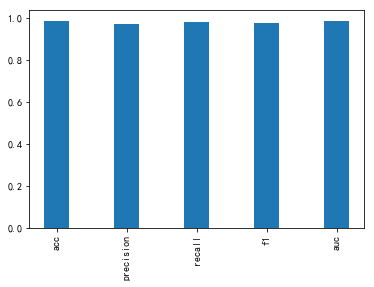

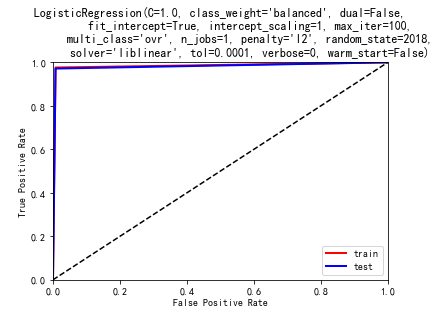

准确率:0.9861,精确率:0.9762,召回率:0.9707,f1-score:0.9734,auc:0.9812


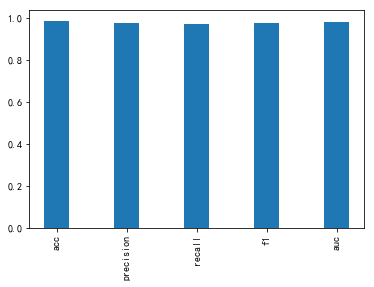

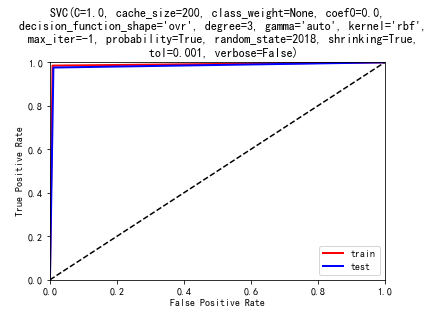

准确率:0.9826,精确率:0.9657,召回率:0.9679,f1-score:0.9668,auc:0.9779


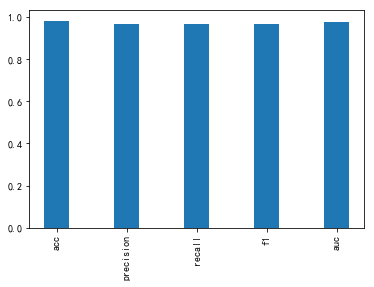

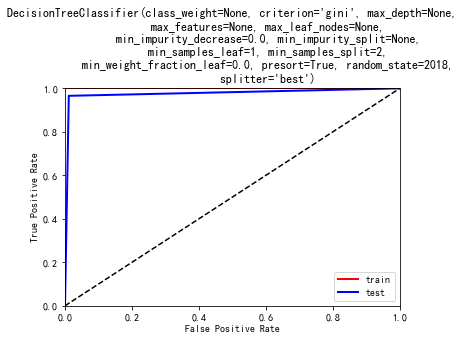

准确率:0.9651,精确率:0.9875,召回率:0.8778,f1-score:0.9294,auc:0.9369


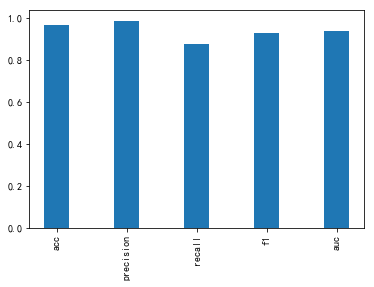

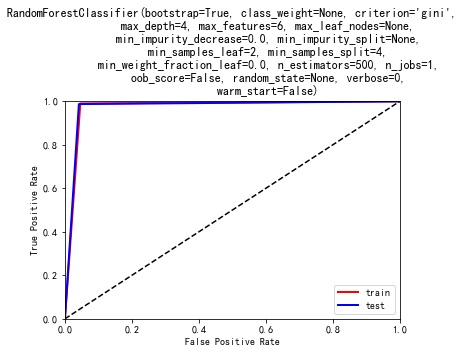

Wall time: 19.6 s


In [72]:
%%time
score_list = []
# 逻辑回归
log = LogisticRegression(class_weight="balanced",random_state=2018)
clf_score(log,x_train,x_test,y_train,y_test,score_list)

# svm
svc = svm.SVC(random_state=2018,probability=True)
clf_score(svc,x_train,x_test,y_train,y_test,score_list)

# 决策树
tree = DecisionTreeClassifier(presort=True,random_state=2018)
clf_score(tree,x_train,x_test,y_train,y_test,score_list)

# 随机森林
forest = RandomForestClassifier(n_estimators=500, min_samples_split=4, min_samples_leaf=2,bootstrap=True, max_depth=4, max_features=6)
clf_score(forest,x_train,x_test,y_train,y_test,score_list)

#### XGBoost参数调优

准确率:0.9912,精确率:0.9801,召回率:0.9865,f1-score:0.9833,auc:0.9897


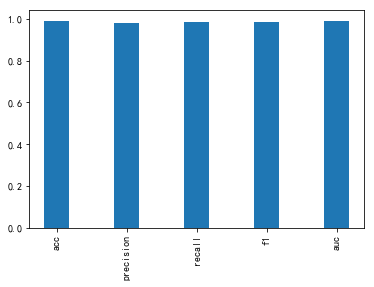

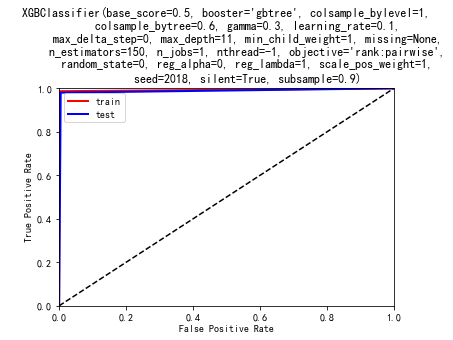

五种模型中平均评分最高的是XGBOOST模型；准确率为：0.9861914590834842


In [51]:
# XGBoost
# n_estimators参数调优

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# 首先对最大迭代次数调优
# param_test = {'n_estimators':range(50,500,50)}
# gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=6, 
#                                                   min_child_weight=1, gamma=0, subsample=0.8, 
#                                                   colsample_bytree=0.8, objective= 'rank:pairwise', 
#                                                   nthread=-1,scale_pos_weight=1, seed=2018), 
#                         param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

# gsearch.fit(x_train, y_train)
# # gsearch.grid_scores_, 
# print(gsearch.best_params_, gsearch.best_score_)
# {'n_estimators': 150} 0.998971247117016

# 接下来对最小子叶权重min_child_weight，最大深度max_depth调参
# 在n_estimators_best = 150条件下 min_child_weight，max_depth参数调优

# param_test = {'max_depth':range(3,15,2), 'min_child_weight':range(1,12,2)}

# gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=5, 
#                                                   min_child_weight=1, gamma=0, subsample=0.8, 
#                                                   colsample_bytree=0.8, objective= 'rank:pairwise', 
#                                                   nthread=3,scale_pos_weight=1, seed=2018), 
#                         param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

# gsearch.fit(x_train, y_train)
# # gsearch.grid_scores_, 
# print(gsearch.best_params_, gsearch.best_score_)
# ({'max_depth': 11, 'min_child_weight': 1} 0.9990822849567141)

# # gamma 参数调优
# param_test = {'gamma':[i/10 for i in range(1,6)]}
# gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=11, 
#                                                   min_child_weight=1, gamma=0, subsample=0.8, 
#                                                   colsample_bytree=0.8, objective= 'rank:pairwise', 
#                                                   nthread=-1,scale_pos_weight=1, seed=2018), 
#                         param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

# gsearch.fit(x_train, y_train)
# # gsearch.grid_scores_, 
# print(gsearch.best_params_, gsearch.best_score_)

# # ({'gamma': 0.3} 0.9990743913021938)

# # subsample 和 colsample_bytree 参数

# param_test = {'subsample':[i/10 for i in range(5,10)], 'colsample_bytree':[i/10 for i in range(5,10)]}
# gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=11, 
#                                                   min_child_weight=1, gamma=0.3, subsample=0.8, 
#                                                   colsample_bytree=0.8, objective= 'rank:pairwise', 
#                                                   nthread=-1,scale_pos_weight=1, seed=2018), 
#                         param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

# gsearch.fit(x_train, y_train)
# # gsearch.grid_scores_, 
# print(gsearch.best_params_, gsearch.best_score_)
# # ({'colsample_bytree': 0.6, 'subsample': 0.9} 0.9991702065044281)

# 降低learning_rate 参数
# param_test = {'learning_rate':[0.001, 0.01, 0.1]}

# gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=11, 
#                                                   min_child_weight=1, gamma=0.3, subsample=0.9, 
#                                                   colsample_bytree=0.6, objective= 'rank:pairwise', 
#                                                   nthread=-1,scale_pos_weight=1, seed=2018), 
#                         param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

# gsearch.fit(x_train, y_train)
# # gsearch.grid_scores_, 
# print(gsearch.best_params_, gsearch.best_score_)

# ({'learning_rate': 0.1} 0.9991702065044281)

xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=150,
 max_depth=11,
 min_child_weight=1,
 gamma=0.3,#惩罚项
 subsample=0.9,#随机选90%的样本
 colsample_bytree=0.6,#随机选特征
 objective= 'rank:pairwise',#lost funation ： logistic
 nthread=-1,
 scale_pos_weight=1,
 seed=2018)
xgb = xgb.fit(x_train,y_train)
clf_score(xgb,x_train,x_test,y_train,y_test,score_list)

models = ["逻辑回归","svm","决策树","随机森林","XGBOOST"]
max_acu = max(score_list)
print("五种模型中平均评分最高的是{}模型；准确率为：{}".format(models[score_list.index(max_acu)],max_acu))


### 模型融合

准确率:0.9920,精确率:0.9776,召回率:0.9921,f1-score:0.9848,auc:0.9920


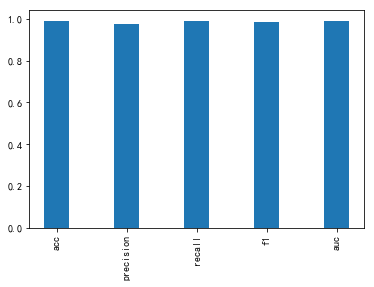

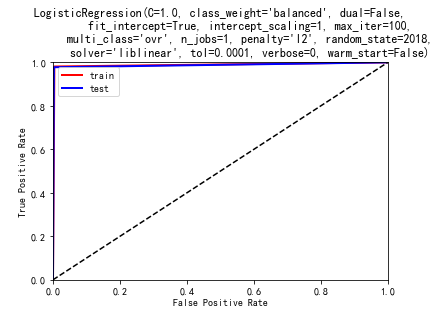

[0.9792183127121685,
 0.9775247109695879,
 0.9721835575853328,
 0.9393282562476555,
 0.9785268722016681,
 0.987685297346216]

In [74]:
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier as GBDT
from sklearn.ensemble import ExtraTreesClassifier as ET
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import AdaBoostClassifier as ADA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np


# 定义第一层模型
# 由于Stacking的第一层最后选择比较强的模型，所以这里选了四个表现比较好的强模型
# xgboost，RandomForest，svm，和 tree。
### 第一层模型
clfs = [xgb,svc,tree,forest]
X_train_stack  = np.zeros((x_train.shape[0], len(clfs)))
X_test_stack = np.zeros((x_test.shape[0], len(clfs))) 

# 数据输入第一层模型，输出每个模型的预测集P,即将作为特征传送给第二层模型训练
### 5折交叉验证stacking
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=2018)
for i,clf in enumerate(clfs):
#     print("分类器：{}".format(clf))
    X_stack_test_n = np.zeros((x_test.shape[0], n_folds))
    for j,(train_index,test_index) in enumerate(skf.split(x_train,y_train)):
        tr_x = x_train.iloc[train_index]
        tr_y = y_train.iloc[train_index]
#         print(tr_x.shape)
#         print(tr_y.shape)
        clf.fit(tr_x, tr_y)
        # 生成stacking训练数据集,即每个模型的训练集生成的预测集，将作为第二层模型的训练特征集
        X_train_stack[test_index, i] = clf.predict_proba(x_train.iloc[test_index])[:,1]
#         print(X_train_stack,X_train_stack.shape)
        # 每个模型的的测试集生成的预测集
        X_stack_test_n[:,j] = clf.predict_proba(x_test)[:,1]
#         print(X_stack_test_n,X_stack_test_n.shape)
    # 生成stacking测试数据集，集合每个模型的的测试集生成的预测集求平均数，将作为第二层模型的测试特征集
    X_test_stack[:,i] = X_stack_test_n.mean(axis=1) 
#     print(X_test_stack,X_test_stack.shape)

# 用第一层模型输出的预测集作为特征训练第二层模型
# 为了防止过拟合，第二层选择了一个简单的Logistics回归模型。输出Stacking模型的auc得分。
clf_second = log
clf_second.fit(X_train_stack,y_train)
pred = clf_second.predict_proba(X_test_stack)[:,1]
roc_auc_score(y_test,pred)
clf_score(clf_second,X_train_stack,X_test_stack,y_train,y_test,score_list)